<a href="https://colab.research.google.com/github/nb0003/chessPieces_ID/blob/main/ChessPieceID_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identifying Chess Pieces ##

In this notebook, we will use several Machine Learning Techniques, including:

*   CNNs
*   Transfer Learning
*   Freezing/Unfreezing
*   Discriminative Learning rates


to identify which chess piece is depicted in an image. Note that we assume that there is exactly one type of chess piece in each image.

Much of the code uses the fastai v2 library, which you can learn more about [here](https://docs.fast.ai/). Additionally, most of the ideas implemented below are rooted in ideas from the [fastai v1 course](https://course.fast.ai/).

Let us begin by importing the necessary libraries:










In [ ]:
!pip install fastai --upgrade -q

In [ ]:
!pip install -Uqq fastbook

In [ ]:
import fastbook


In [ ]:
import torchvision

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

Since our training images are in folders in Google Drive, we will mount to Google Drive.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
from PIL import Image

In [ ]:
#Changing directory to My Drive
os.chdir('/content/drive/My Drive/Pieces')
!ls

Bishop	export.pkl  King  Knight  models  Pawn	Queen  Rook


## Data Source(s) ##

I have created a different folder for each chess piece, with about 50-100 images per folder. In total, I used 485 pictures for training. To obtain most of these pictures, I scraped Google Images (using [Image Downloader](https://chrome.google.com/webstore/detail/image-downloader-imageye/agionbommeaifngbhincahgmoflcikhm?hl=en-US)) for the first few pages for each piece. Subsequently, I hand-picked a subset of the results to ensure accuracy and high-quality images.

Upon training a model on only the Google Image data, I attained a high accuracy rate (98%). However, when I decided to run inference with pictures that I took myself, I discovered that the model was far less accurate than I thought.

Thus, I added these new images into the training data, in the hopes of improving the model's validity (with respect to user-submitted images).

In [ ]:
path = '/content/drive/My Drive/Pieces'
pieces = ['Rook','Knight','Bishop','King','Pawn','Queen']

for piece in pieces:
  for filename in os.listdir(path + "/" + piece):
    print (filename)

In [ ]:
fns=[get_image_files(path + "/" + piece) for piece in pieces]
fns

## Image Clean-up ##

In earlier versions, I had issues with PNG files with transparent backgrounds: these images would show up as completely black. So, let's change transparent backgrounds to white backgrounds:

In [ ]:
#Only need to do these next steps once:
for piece in pieces:
  a_path = path + "/" + piece
  for pic in os.listdir(a_path):
    the_path = a_path + "/" + pic
    if 'EDITED' not in (the_path):
      png = Image.open(the_path).convert('RGBA')
      background = Image.new('RGBA', png.size, (255,255,255))
      alpha_composite = Image.alpha_composite(background, png).convert('RGB')
      alpha_composite.save(a_path + "/EDITED" + pic, 'JPEG', quality=80)
#Now we need to delete all images which don't have EDITED in their filename

In [ ]:
#deleting unedited files
for piece in pieces:
  a_path = path + "/" + piece
  for pic in os.listdir(a_path):
    the_path = a_path + "/" + pic
    if 'EDITED' not in (the_path):
      os.remove(the_path)

In [ ]:
#confirming that all files have been edited:
unedited_count = 0
for piece in pieces:
  a_path = path + "/" + piece
  for pic in os.listdir(a_path):
    the_path = a_path + "/" + pic
    if 'EDITED' not in (the_path):
      unedited_count += 1
print(unedited_count)

0


All of the pictures which I took ended up being rotated 90 degrees counterclockwise, so we rotate them below:

In [ ]:
#We need to rotate the 24 pictures
#First we confirm there are exactly 24:
bad_pic_count = 0
for piece in pieces:
  a_path = path + "/" + piece
  for pic in os.listdir(a_path):
    the_path = a_path + "/" + pic
    if 'EDITEDpp' in (the_path) or 'EDITEDIMG_2021' in (the_path):
      bad_pic_count += 1

print(bad_pic_count)

24


In [ ]:
#only need to do this once
for piece in pieces:
  a_path = path + "/" + piece
  for pic in os.listdir(a_path):
    the_path = a_path + "/" + pic
    if 'EDITEDpp' in (the_path) or 'EDITEDIMG_2021' in (the_path):
      im = Image.open(the_path)
      im = im.rotate(-90)
      im.save(a_path + "/" + "REEDITED" + pic, 'JPEG')

In [ ]:
#confirming all 24 pics were updated
re_edited_count = 0
for piece in pieces:
  a_path = path + "/" + piece
  for pic in os.listdir(a_path):
    the_path = a_path + "/" + pic
    if 'REEDITED' in (the_path):
      re_edited_count += 1

print(re_edited_count)

24


After deleting the duplicates resulting from the above code, we will set up training.

## Final Set-up ##

In [ ]:
#creating a DataBlock
chess_pieces = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=40),
    get_y=parent_label,
    item_tfms=Resize(460,method='squish'),
    batch_tfms=[*aug_transforms(size=224,xtra_tfms=None)])

Let's do a line-by-line analysis of the above code.

- We start training by creating a **DataBlock** of the chess piece images. The DataBlock API is a fastai system which allows for various option during training
- The **blocks** argument takes a tuple of an independent and dependent variable. In this case, our set of images is the independent variable, and the dependent variable is the predicted category of the images
- The **get_items** line simply retrieves our images
- **splitter** splits our dataset into the training set and validation set; the arguments specify that the validation set will be 20% of the data, and it will be the same set each time
- With the next line, we are saying that the label of each image is simply the name of its parent folder (i.e. a picture in the Bishop folder has a true label of Bishop)
- The **item_tfms** line transforms each image individually by 'squishing' to a 460x460 picture
-Finally, the **batch_tfms** applies [*aug_transforms](https://docs.fast.ai/vision.augment.html#aug_transforms) (data augmentation) to entire batches at a time. We use a GPU here, which greatly expedites the process

Note that we avoided cropping images, as that would make it hard to distinguish pieces like King and Queen or Pawn and Bishop.

In [ ]:
#creating a dataloaders
dls = chess_pieces.dataloaders(path)

In [ ]:
dls.after_item

Pipeline: Resize -- {'size': (460, 460), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor

In [ ]:
dls.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}

We made the train/valid sets available with dataloaders, and then confirmed that the item and batch transforms were actually occurring in the next two lines.

To make sure everything is going as planned, let's look at some (transformed) pictures from the validation set:

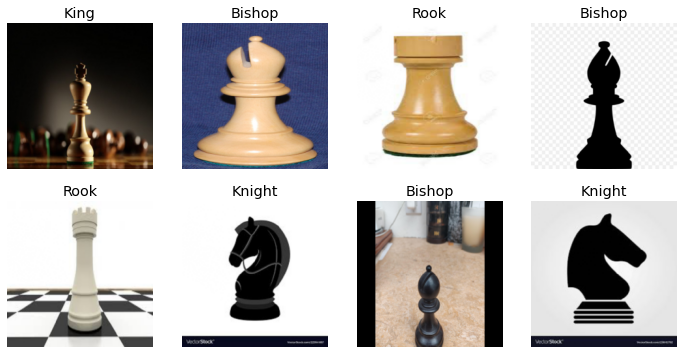

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

## Training ##

Before training, let's review some ML terminology:

- An **epoch** is one pass through the entire training set
- The **loss function** is the model's measure of performance, which it actually uses to alter weights
- The error rate is the rate of misclassification in the **validation** set; it is an intuitive metric


Let's train with a [Convolutional Neural Net](https://en.wikipedia.org/wiki/Convolutional_neural_network) (or CNN) for 10 epochs to establish a baseline error rate:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.898241,1.920932,0.659794,01:12


epoch,train_loss,valid_loss,error_rate,time
0,1.645050,1.390106,0.453608,00:15
1,1.350735,0.999081,0.360825,00:15
2,1.076139,0.616832,0.237113,00:15
3,0.834542,0.427443,0.154639,00:15
4,0.667306,0.390612,0.123711,00:15
5,0.545090,0.339460,0.113402,00:15
6,0.445419,0.333525,0.113402,00:15
7,0.375972,0.325945,0.103093,00:15
8,0.323544,0.326353,0.092783,00:15
9,0.287200,0.329344,0.113402,00:15


Note that **cnn_learner** uses a pre-trained model by default. This is highly valuable, as the model taps into training from millions of images. We will not reset the weights from most of these layers, but instead only change the last few (using **fine_tune**).

Here, we establish a baseline error rate of ~11%.

Next, let's look at what kind of misclassifications our NN is making:

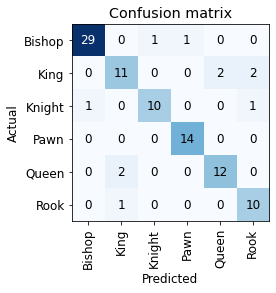

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=2)

[('King', 'Queen', 2), ('King', 'Rook', 2), ('Queen', 'King', 2)]






The top mistake involves Kings and Queens. This makes sense, as the pieces look quite alike.

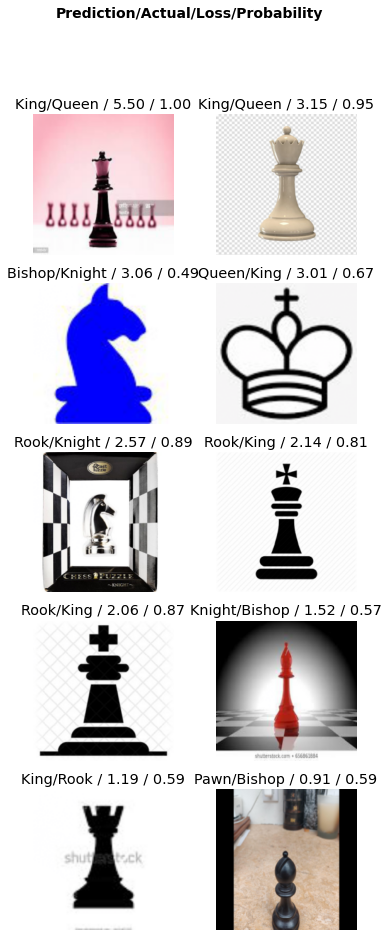

In [ ]:
interp.plot_top_losses(10, nrows=5)

We see that the model is making some understandable mistakes, like King/Queen, Queen/King, and Pawn/Bishop. It is also making weird mistakes, like Bishop/Knight and Rook/King. Since there is not much training data (and the parameters were not optimal), these mistakes are to be expected.

## Learning Rates and LR Finder ##

The **learning rate** (of the loss function) indicates the step size of each iteration in converging toward the function's minimum. It is called the learning rate because it represents how quickly the model adapts to new information. In practice, [setting learning rates too high or low](https://en.wikipedia.org/wiki/Learning_rate#:~:text=In%20machine%20learning%20and%20statistics,minimum%20of%20a%20loss%20function.&text=In%20setting%20a%20learning%20rate,rate%20of%20convergence%20and%20overshooting.) can prevent the model from reaching the real minimum.

The learning rate finder implements a simple but effective idea: it records the loss with a low learning rate after a small batch, and then doubles the learning rate and repeats the process. A general rule of thumb for choosing a learning rate is to find where the loss is clearly decreasing, but not at the minimum.

Let's use the learning rate finder to discover a better learning rate:

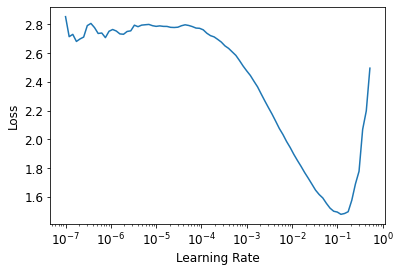

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 4.37e-03


Somewhere between **2e-3** and **4e-3** seems to be the optimal learning rate range in this case. Let's train with lrs in this range for 10 epochs:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10,base_lr=4e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.555696,1.470197,0.494845,00:15


epoch,train_loss,valid_loss,error_rate,time
0,1.258335,1.017477,0.391753,00:15
1,0.886242,0.699215,0.278351,00:15
2,0.664243,0.413310,0.185567,00:15
3,0.494111,0.472541,0.134021,00:15
4,0.382206,0.565975,0.123711,00:15
5,0.305922,0.340372,0.092784,00:15
6,0.254332,0.350300,0.092784,00:15
7,0.212121,0.378272,0.103093,00:15
8,0.179439,0.385995,0.103093,00:15
9,0.156087,0.383356,0.103093,00:15


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10,base_lr=3.5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.598911,1.480253,0.536082,00:14


epoch,train_loss,valid_loss,error_rate,time
0,1.257961,0.758106,0.309278,00:15
1,0.901265,0.684910,0.268041,00:15
2,0.655610,0.629211,0.175258,00:15
3,0.495834,0.513109,0.164948,00:15
4,0.389121,0.388629,0.134021,00:15
5,0.312625,0.357243,0.092783,00:15
6,0.257153,0.412237,0.092783,00:15
7,0.218547,0.422204,0.113402,00:15
8,0.185846,0.419377,0.103093,00:15
9,0.158979,0.423169,0.103093,00:15


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10,base_lr=3.25e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.805218,1.726365,0.515464,00:14


epoch,train_loss,valid_loss,error_rate,time
0,1.381833,1.070686,0.360825,00:15
1,1.033315,0.640818,0.257732,00:15
2,0.789877,0.377984,0.144330,00:15
3,0.601207,0.368904,0.113402,00:15
4,0.488256,0.570771,0.123711,00:15
5,0.391349,0.544625,0.164948,00:15
6,0.321352,0.486249,0.134021,00:15
7,0.267074,0.439351,0.113402,00:15
8,0.224837,0.414140,0.113402,00:15
9,0.192350,0.417218,0.113402,00:15


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10,base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.668848,1.847781,0.577320,00:15


epoch,train_loss,valid_loss,error_rate,time
0,1.318702,1.136924,0.391753,00:15
1,1.037229,0.889332,0.309278,00:15
2,0.769000,0.807894,0.216495,00:15
3,0.575065,0.702389,0.185567,00:15
4,0.454082,0.765721,0.206186,00:15
5,0.367705,0.662203,0.175258,00:15
6,0.301807,0.530273,0.144330,00:15
7,0.254114,0.458738,0.123711,00:15
8,0.213919,0.448568,0.134021,00:15
9,0.185333,0.444233,0.134021,00:15


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10,base_lr=2.75e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.575065,1.575785,0.546392,00:14


epoch,train_loss,valid_loss,error_rate,time
0,1.472967,1.060809,0.443299,00:15
1,1.144904,0.747736,0.278351,00:15
2,0.885497,0.521544,0.195876,00:15
3,0.670784,0.360855,0.123711,00:15
4,0.527568,0.316769,0.082474,00:15
5,0.424010,0.371110,0.113402,00:15
6,0.348414,0.340256,0.092784,00:15
7,0.289372,0.340350,0.092784,00:15
8,0.243302,0.338675,0.092784,00:15
9,0.208931,0.341529,0.092784,00:16


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10,base_lr=2.5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.776037,1.481017,0.525773,00:15


epoch,train_loss,valid_loss,error_rate,time
0,1.404789,1.131945,0.402062,00:15
1,1.130427,0.797942,0.268041,00:15
2,0.896106,0.569896,0.226804,00:16
3,0.693309,0.333937,0.144330,00:15
4,0.542477,0.286144,0.123711,00:15
5,0.441391,0.307967,0.103093,00:16
6,0.364804,0.347422,0.092783,00:15
7,0.303647,0.366297,0.092783,00:15
8,0.257230,0.355731,0.082474,00:15
9,0.220624,0.351293,0.082474,00:15


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10,base_lr=2.25e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.820687,1.762029,0.515464,00:15


epoch,train_loss,valid_loss,error_rate,time
0,1.423524,0.997849,0.340206,00:15
1,1.191916,0.660641,0.237113,00:15
2,0.938951,0.497392,0.216495,00:15
3,0.765418,0.561041,0.206186,00:15
4,0.611586,0.408189,0.134021,00:15
5,0.496943,0.417153,0.154639,00:15
6,0.404129,0.421315,0.134021,00:15
7,0.341922,0.389562,0.134021,00:16
8,0.291411,0.374623,0.113402,00:15
9,0.248309,0.371455,0.123711,00:15


In this case, it seems that **2.5e-3** is a good learning rate, yielding a ~92% accuracy rate. We can do better than this, however.


## Freezing, Unfreezing, and Discriminative Learning Rates ##

As we recall, **cnn_learner** uses a pre-trained model by default. To ensure that we do not change the weights of the earlier layers, we used **fine_tune**. However, it is possible to improve on this idea with the following process:

- First, we train the last layers for a few epochs
- Next, we unfreeze the model
- Then, we find the new optimal lr (since we've trained for a few epochs, the old lr is not necessarily best)


In [ ]:
#train for three epochs at the old lr
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 2.5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.604173,1.898883,0.546392,00:15
1,1.766480,1.257383,0.402062,00:14
2,1.346776,1.086958,0.350515,00:15


SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=8.31763736641733e-06)

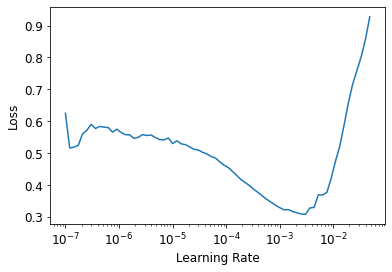

In [ ]:
#unfreeze the model and find new optimal lr
learn.unfreeze()
learn.lr_find()

It seems like **3e-4** is a good lr after unfreezing. We could somewhat improve the process by adjusting the lr during succesive epochs. We will maintain a lower lr for the deeper, established layers, and (logarithmically) work our way up to a higher lr for these last layers. This is known as using **discriminative learning rates**.

Thus, our process is:

- Train at the old lr (**2.5e-3**) for a few epochs
- Unfreeze
- Train for a large number of epochs (say 25), starting out with the new lr (**3e-4**) and increasing (to **3e-3**)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 2.5e-3)
learn.unfreeze()
learn.fit_one_cycle(25, lr_max=slice(3e-4,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.645349,1.670192,0.515464,00:15
1,1.745034,1.233018,0.340206,00:15
2,1.303174,1.085295,0.381443,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.495406,0.870306,0.298969,00:16
1,0.387935,0.698765,0.206186,00:16
2,0.288320,0.519544,0.092784,00:15
3,0.237398,0.265801,0.072165,00:16
4,0.211790,1.333360,0.237113,00:15
5,0.204157,1.189885,0.175258,00:16
6,0.238788,2.545563,0.216495,00:15
7,0.283119,15.014530,0.463918,00:15
8,0.273517,2.748161,0.185567,00:15
9,0.252211,0.314168,0.041237,00:15


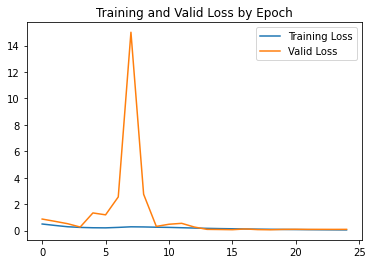

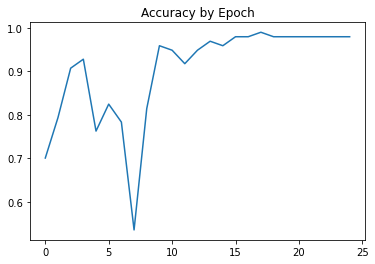

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
#want to graph the above
#g1: epoch number on x-axis, and train/valid loss on right
#g2: epoch number on x-axis, and accuracy on right
a_string = '''0	0.495406	0.870306	0.298969	00:16
1	0.387935	0.698765	0.206186	00:16
2	0.288320	0.519544	0.092784	00:15
3	0.237398	0.265801	0.072165	00:16
4	0.211790	1.333360	0.237113	00:15
5	0.204157	1.189885	0.175258	00:16
6	0.238788	2.545563	0.216495	00:15
7	0.283119	15.014530	0.463918	00:15
8	0.273517	2.748161	0.185567	00:15
9	0.252211	0.314168	0.041237	00:15
10	0.239392	0.476799	0.051546	00:15
11	0.214389	0.546664	0.082474	00:15
12	0.188978	0.265122	0.051546	00:15
13	0.166229	0.089105	0.030928	00:15
14	0.147845	0.078891	0.041237	00:15
15	0.133578	0.064657	0.020619	00:15
16	0.119798	0.119310	0.020619	00:15
17	0.105888	0.071373	0.010309	00:16
18	0.094991	0.058901	0.020619	00:15
19	0.084075	0.086453	0.020619	00:15
20	0.075679	0.094529	0.020619	00:15
21	0.067381	0.087446	0.020619	00:15
22	0.059572	0.089935	0.020619	00:16
23	0.053253	0.087338	0.020619	00:15
24	0.047845	0.090152	0.020619	00:15'''

#creating a df with columns like above
l = re.split('\n',a_string)
column_names = ['Epoch','train_loss','valid_loss','error_rate','time']
df = pd.DataFrame(columns = column_names)
for i in range(len(l)):
  df.loc[i] = re.split('\t', l[i])
#dropping the time column
df = df.drop(['time'],axis = 1)

#casting columns to numeric types
df['Epoch'] = pd.to_numeric(df['Epoch'],downcast='signed')
for col in ['train_loss','valid_loss','error_rate']:
  df[col] = pd.to_numeric(df[col])
#print(df.dtypes)
df['accuracy'] = df.apply(lambda row: 1 - row['error_rate'],axis=1)

#graphing
x = df['Epoch']
a = df['train_loss']
b= df['valid_loss']
ax1= plt.plot(x,a,b)
plt.legend(['Training Loss','Valid Loss'])
plt.title('Training and Valid Loss by Epoch')
plt.show()
ax2 = plt.plot(x,df['accuracy'])
plt.title('Accuracy by Epoch')
plt.show()


For most of the training, we see that the valid loss and training loss were both decreasing. The validation loss varied more because it is a smaller set. It does not seem like overfitting occurred, as the valid loss did **not** significantly increase while the training loss decreased (in later epochs).

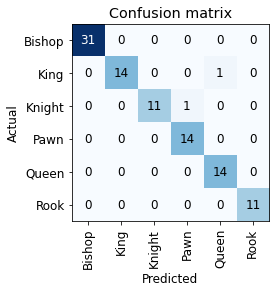

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Let's look at which images caused the greatest loss:

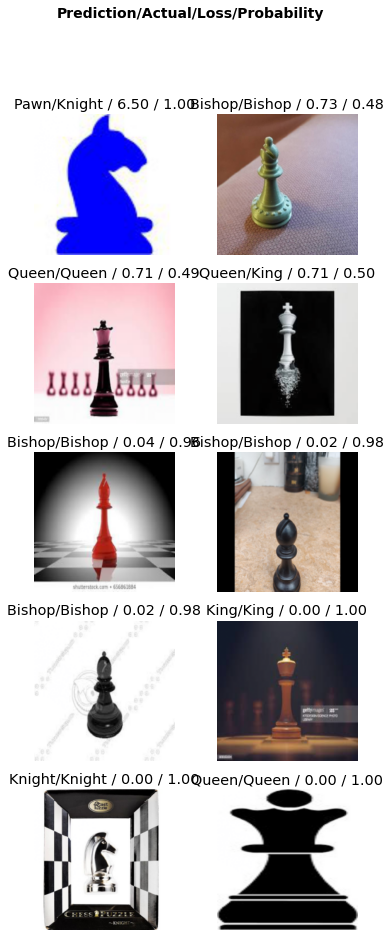

In [ ]:
interp.plot_top_losses(10, nrows=5)

The text above each image represents the model's prediction, the actual label, the loss, and the model's confidence in its prediction. We see that the two mistakes it made were: labeling the top left knight as a pawn and the (diagonally below) king for a queen. Both pieces are highly nonstandard in their representations, so these errors are acceptable.

It seems that discriminative learning rates and freezing/unfreezing improved our accuracy considerably, with a 2% error rate!

We expect that in the real world, our model might not perform so well. Here are a few explanations for our high accuracy:
- The model is overfitting
- The task is very simple
- The training/validation sets are too similar

Each of these explanations has some relevance in our case. The most indisputable point is the third, as the images are fairly homogenous. This is because they are mainly from Google Images, and:
- None of the pictures are from an aerial view
- Each piece occupies a significant portion of the frame
- The lighting/contrast is optimal
- The backgrounds are mostly devoid of information

We suspect that user-submitted images are harder to classify. To assess the model's real-world validity, I will have it predict pictures of pieces from two new sets.

Let's first save this architecture with its parameters as above, so that we may run inference.

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

## Running Inference ##

Recall that the first time I ran this model, it didn't accurately predict real pictures I submitted. We hope that the model has improved with the inclusion of a set of real-life pieces.

Let us run inference on two fairly standard sets of pieces and calculate the model's accuracy.

In [ ]:
#We will loop through the images in the 'Practice' folder and then tabulate accuracy
new_path = '/content/drive/My Drive/Practice'
correct_count = 0
for file in os.listdir(new_path):
  image_path = new_path + "/" + file
  img = Image.open(image_path)
  #print(img.shape, type(img))
  img = PILImage(PILImage.create(image_path).rotate(-90).resize((224,224)))
  #print(img.shape, type(img))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred = widgets.Label()
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
  if pred.lower() in str(image_path):
    correct_count +=1
  else:
    print(str(file))

accuracy = correct_count/24
print('Our accuracy during inference was ' "{:.2%}".format(accuracy))

set1wrook.jpg


set1brook.jpg


set2bking.jpg


Our accuracy during inference was 87.50%


At first, the model correctly identifies 21 out of 24 pieces. This is not an awful result, but we could expect better.

Let us look at the errors it made:

In [ ]:
image_path = new_path + "/" + 'set1wrook.jpg'
img = Image.open(image_path)
#print(img.shape, type(img))
img = PILImage(PILImage.create(image_path).rotate(-90).resize((224,224)))
#print(img.shape, type(img))

pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
print(lbl_pred.value)

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl


Prediction: Pawn; Probability: 0.8873


Output()

In [ ]:
image_path = new_path + "/" + 'set1brook.jpg'
img = Image.open(image_path)
#print(img.shape, type(img))
img = PILImage(PILImage.create(image_path).rotate(-90).resize((224,224)))
#print(img.shape, type(img))

pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
print(lbl_pred.value)

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Prediction: Pawn; Probability: 0.9892


Output()

In [ ]:
image_path = new_path + "/" + 'set2bking.jpg'
img = Image.open(image_path)
#print(img.shape, type(img))
img = PILImage(PILImage.create(image_path).rotate(-90).resize((224,224)))
#print(img.shape, type(img))

pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
print(lbl_pred.value)

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl


Prediction: Rook; Probability: 0.8142


Output()

The errors which the model made are strange: it classified the two rooks as pawns, and the king as a rook. To a human, none of these pieces look alike. Perhaps issues with angles and lighting contributed to the misclassification.



Let's take new pictures of the same pieces and see if that improves our results.

## Inference with Improved Images ##

In [ ]:
image_path = new_path + "/" + 'set1wrook2.jpg'
img = Image.open(image_path)
#print(img.shape, type(img))
img = PILImage(PILImage.create(image_path).rotate(-90).resize((224,224)))
#print(img.shape, type(img))

pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
print(lbl_pred.value)

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Prediction: Rook; Probability: 0.9981


Output()

In [ ]:
image_path = new_path + "/" + 'set1brook2.jpg'
img = Image.open(image_path)
#print(img.shape, type(img))
img = PILImage(PILImage.create(image_path).rotate(-90).resize((224,224)))
#print(img.shape, type(img))

pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
print(lbl_pred.value)

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Prediction: Rook; Probability: 1.0000


Output()

In [ ]:
image_path = new_path + "/" + 'set2bking2.jpg'
img = Image.open(image_path)
#print(img.shape, type(img))
img = PILImage(PILImage.create(image_path).rotate(-90).resize((224,224)))
#print(img.shape, type(img))

pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
print(lbl_pred.value)

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Prediction: King; Probability: 1.0000


Output()

Somewhat surprisingly, the model now correctly predicts all of the pieces (with high confidence)! Here are some of the small changes made to the second set of pictures:
- lower vantage point
- pieces closer to camera
- background less visible
- more focus on each piece's details
- better lighting

Most of these changes make the pictures more closely resemble the images which the model was trained on. Still, the model managed to correctly predict two full sets of pieces!

## Conclusion ##

After training a CNN for 25 epochs on Google Image data (and a few real-life pictures), we achieved a 2% error rate on the validation set. More importantly, the model scored a ~100% accuracy rate on real-life images. Achieving this level of accuracy was straightforward, with the help of:
- Transfer learning
- The learning rate finder
- Freezing, unfreezing, and discriminative learning rates
- The fastai library and course

We must reiterate that in order for the model to achieve maximum accuracy, each picture should:
- occupy a significant portion of the frame
- be from a non-aerial view
- be clearly focused on the piece(s)
- depict standard chess piece(s)

It is not ideal that the model could not predict a few of the images **before** the angle/lighting changes. A human could easily classify those images, so a ML model should be able to as well.

To improve the model's real-world validity, I would need to gather more real-life images (with varying aforementioned conditions).
As always, the difficulty in this task is the data collection.

